In [1]:
# ref 
# https://github.com/thushv89/datacamp_tutorials/blob/master/Reviewed/lstm_stock_market_prediction.ipynb
# https://www.datacamp.com/community/tutorials/lstm-python-stock-market?utm_medium=fb%2Cig%2Can%2Cms-all&utm_source=fb_paid&utm_campaign=smartly_ppa&utm_id=5aeb1906839578043e0fa33b



In [2]:
# Make sure that you have all these libaries available to run the code successfully

# ops 
import datetime as dt
import urllib.request, json 
import os
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt

# ML 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler


/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# help functions 

def get_data(fine_name):
	print (fine_name)
	df = pd.read_csv('data/{}.csv'.format(fine_name))
	print (df.head())
	return df  

def col_fix(df):
    df = df.drop('Unnamed: 0', axis=1) 
    print (df.columns)
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    #df['Date'] = pd.to_datetime(df['Date'] )
    print (df.head())
    return df 

def get_train_data(df):
	#df_expo = df[df.drop_off_addr == 'expo']
	#dataset = df_expo.groupby('timestamp_live_vec_table')\
	#				 .median()[['lag_idle_day']]\
	#				 .values
	#dataset = df[['Volume','High','Open']].values.astype('float32')
	dataset = df[['Open']].values.astype('float32')
	#print (shape(dataset))
	print (dataset) 
	return dataset

In [20]:
df_FB = get_data('FB')
df_FB_ = col_fix(df_FB)
#dataset = get_train_data(df_FB_)

FB
   Unnamed: 0        Date    Open    High     Low   Close    Volume
0           0  2018-04-12  166.98  167.45  163.10  163.87  38262956
1           1  2018-04-11  165.36  168.65  163.25  166.32  56144633
2           2  2018-04-10  157.93  165.98  157.01  165.04  58947041
3           3  2018-04-09  157.82  160.53  156.04  157.93  34915227
4           4  2018-04-06  157.73  161.42  156.81  157.20  41644812
Index(['Date', ' Open', ' High', ' Low', ' Close', ' Volume'], dtype='object')
         Date    Open    High     Low   Close    Volume
0  2018-04-12  166.98  167.45  163.10  163.87  38262956
1  2018-04-11  165.36  168.65  163.25  166.32  56144633
2  2018-04-10  157.93  165.98  157.01  165.04  58947041
3  2018-04-09  157.82  160.53  156.04  157.93  34915227
4  2018-04-06  157.73  161.42  156.81  157.20  41644812


In [5]:
# re-order the datetime 
# https://stackoverflow.com/questions/28161356/sort-pandas-dataframe-by-date

df_FB_.Date= pd.to_datetime(df_FB_['Date'])
df_FB_= df_FB_.sort_values('Date')
df_FB_.head(3)

,Date,Open,High,Low,Close,Volume
1483,2012-05-18,42.05,45.00,38.00,38.2318,580587742
1482,2012-05-21,36.53,36.66,33.00,34.0300,168309831
1481,2012-05-22,32.61,33.59,30.94,31.0000,102053826


In [6]:
len(df_FB_)

1484

In [7]:
df_FB_.shape[0]

range(0,df_FB_.shape[0],30)

range(0, 1484, 30)

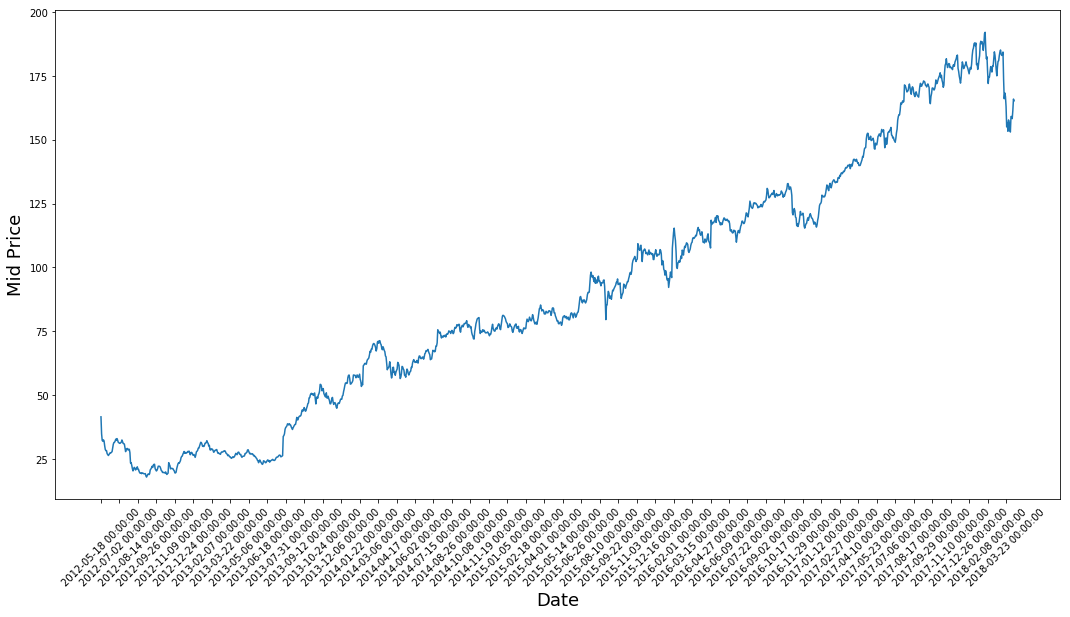

In [8]:
plt.figure(figsize = (18,9))
plt.plot(range(df_FB_.shape[0]),(df_FB_['Low']+df_FB_['High'])/2.0)
plt.xticks(range(0,df_FB_.shape[0],30),df_FB_['Date'].loc[::30],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [9]:
df_FB_.head(3)

,Date,Open,High,Low,Close,Volume
1483,2012-05-18,42.05,45.00,38.00,38.2318,580587742
1482,2012-05-21,36.53,36.66,33.00,34.0300,168309831
1481,2012-05-22,32.61,33.59,30.94,31.0000,102053826


In [10]:
# Breaking Data to Train and Test and Normalizing Data

# First calculate the mid prices from the highest and lowest 
high_prices = df_FB_.loc[:,'High'].as_matrix()
low_prices = df_FB_.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

In [11]:
# get train- test data 

train_data = mid_prices[:1000]
test_data = mid_prices[1000:]

In [12]:
len(test_data)

484

In [13]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data w.r.t training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [14]:
# Train the Scaler with training data and smooth data 
smoothing_window_size = 20
for di in range(0,900,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data 
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [15]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [16]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(1000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [17]:
window_size = 20
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    
    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df_FB_.loc[pred_idx,'Date']
        
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00645


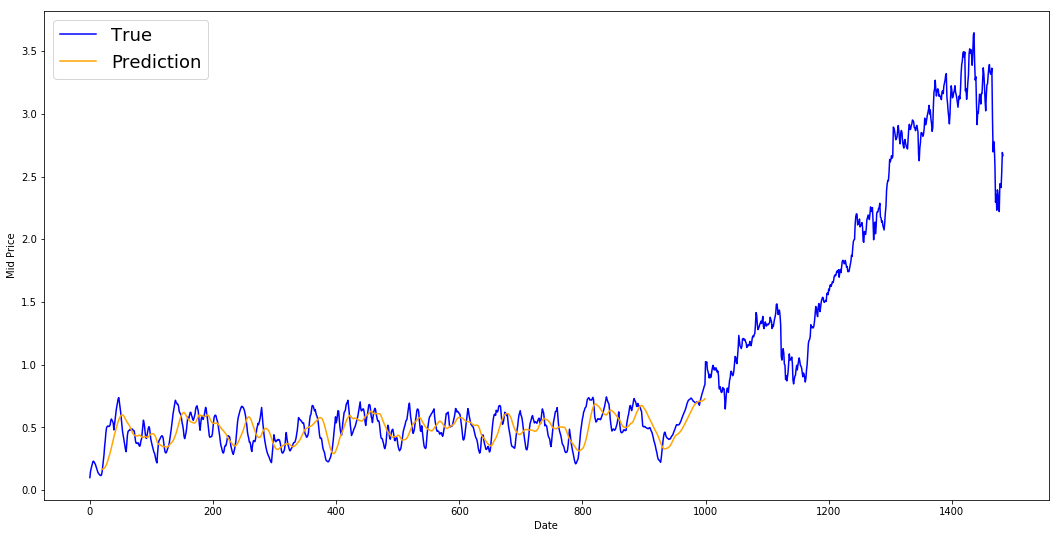

In [18]:
plt.figure(figsize = (18,9))
plt.plot(range(df_FB_.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

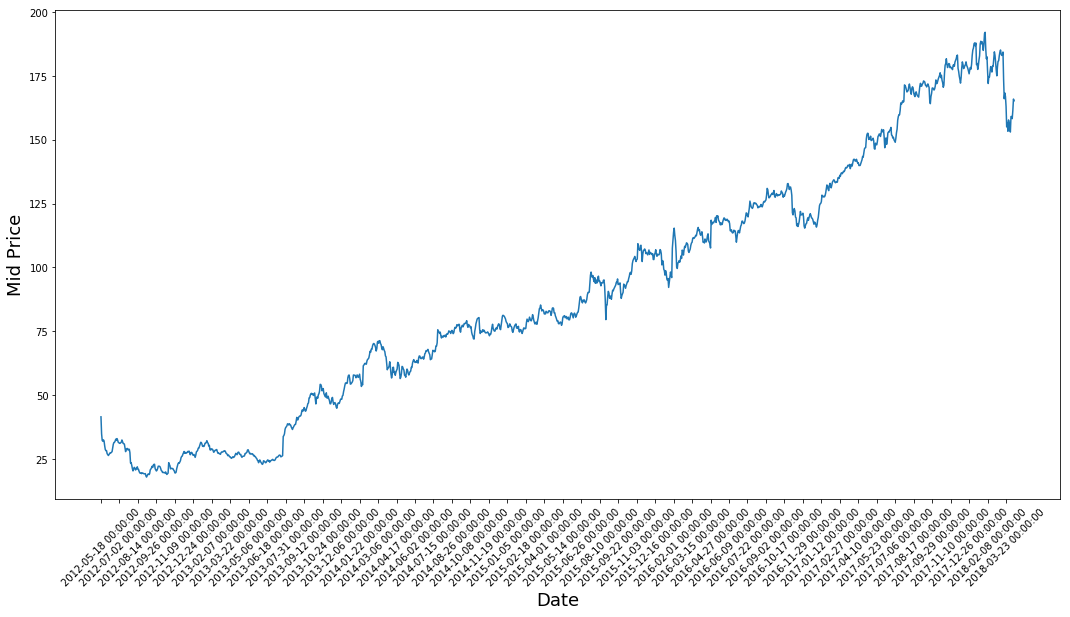

In [19]:
plt.figure(figsize = (18,9))
plt.plot(range(df_FB_.shape[0]),(df_FB_['Low']+df_FB_['High'])/2.0)
plt.xticks(range(0,df_FB_.shape[0],30),df_FB_['Date'].loc[::30],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()